# Market profile

In [28]:
today = '20240124'               # change day of interest
sym = 'ITC.NS'
     

In [29]:
import pandas as pd
import numpy as np
import yfinance as yf
from datetime import datetime, timedelta
import plotly.graph_objects as go
     

In [30]:
def volume_profile(df, price_pace=0.25, return_raw=False):
    """
    create volume profile
    :param df: time-indexed HOLCV bar or time-indexed P-V tick
    :param price_pace: price bucket, default 5 cents
    :param return_raw: return raw data or figure
    :return: raw data or figure obj
    """

    cmin = min(df.Close)
    cmax = max(df.Close)
    cmin_int = int(cmin / price_pace) * price_pace  # int(0.9) = 0
    cmax_int = int(cmax / price_pace) * price_pace
    if cmax_int < cmax:
        cmax_int += price_pace
    cmax_int += price_pace  # right bracket is not included in arrange

    price_buckets = np.arange(cmin_int, cmax_int, price_pace)
    price_coors = pd.Series(price_buckets).rolling(2).mean().dropna()
    vol_bars = np.histogram(df.Close, bins=price_buckets, weights=df.Volume)[0]

    if return_raw:
        return (price_coors.values, vol_bars)

    fig1 = go.Candlestick(
        x=df.index,
        open=df.Open,
        high=df.High,
        low=df.Low,
        close=df.Close,
        xaxis='x',
        yaxis='y2',
        visible=True,
        showlegend=False
    )

    fig2 = go.Bar(
        x=df.index,
        y=df.Volume,
        yaxis='y',
        name='Volume',
        showlegend=False
    )

    fig3 = go.Bar(
        x=vol_bars,
        y=price_coors.values,
        orientation='h',
        xaxis='x2',
        yaxis='y3',
        visible=True,
        showlegend=False,
        marker_color='blue',
        opacity=0.2
    )

    low = cmin_int
    high = cmax_int
    layout = go.Layout(
        title=go.layout.Title(text="Volume Profile"),
        xaxis=go.layout.XAxis(
            side="bottom",
            title="Date",
            rangeslider=go.layout.xaxis.Rangeslider(visible=False)
        ),
        yaxis=go.layout.YAxis(
            side="right",
            title='Volume',
            showticklabels=False,
            domain=[0, 0.2]
        ),
        yaxis2=go.layout.YAxis(
            side="right",
            title='Price',
            range=[low, high],
            domain=[0.2, 1.0]
        ),
        xaxis2=go.layout.XAxis(
            side="top",
            showgrid=False,
            # volume bar on the right
            # unfortunately reversed is an auto-range
            # one solution is to add an invisible bar.
            # https://community.plotly.com/t/reversed-axis-with-range-specified/3806
            # autorange='reversed',
            ticks='',
            showticklabels=False,
            range=[0, int(vol_bars.max() * 5)],
            overlaying="x"
        ),
        yaxis3=go.layout.YAxis(
            side="left",
            range=[low, high],
            showticklabels=False,
            overlaying="y2"
        ),
    )

    fig = go.Figure(data=[fig1, fig2, fig3], layout=layout)

    return fig

In [31]:
def market_profile(df, price_pace=0.25, time_pace='30T', return_raw=False):
    """
    create market profile
    :param df: time-indexed HOLCV bar or time-indexed P-V tick
    :param price_pace: price bucket, default 5 cents
    :param time_pace: time bucket, default to 30min (30T)
    :param return_raw: return raw data or figure
    :return: raw data or figure obj
    """
    cmin = min(df.Low)
    cmax = max(df.High)
    cmin_int = int(cmin / price_pace) * price_pace  # int(0.9) = 0
    cmax_int = int(cmax / price_pace) * price_pace
    if cmax_int < cmax:
        cmax_int += price_pace
    cmax_int += price_pace  # right bracket is not included in arrange

    price_buckets = np.arange(cmin_int, cmax_int, 0.25)
    price_coors = pd.Series(price_buckets).rolling(2).mean().dropna()
    df_agg = df.resample(time_pace).agg({'High': 'max', 'Low': 'min'})
    tpo_bars = np.zeros([price_buckets.shape[0] - 1, df_agg.shape[0]], dtype=np.int32)
    j = 0
    for idx, row in df_agg.iterrows():
        time_bars = np.histogram([row.Low, row.High], bins=price_buckets)[0]
        result = np.where(time_bars == 1)[0]
        if result.shape[0] == 2:
            time_bars[result[0]:result[1] + 1] = 1

        tpo_bars[:, j] = time_bars
        j += 1

    if return_raw:
        return (price_coors.values, tpo_bars)

    fig = go.Figure()

    fig1 = go.Candlestick(
        x=df.index,
        open=df.Open,
        high=df.High,
        low=df.Low,
        close=df.Close,
        xaxis='x',
        yaxis='y2',
        visible=True,
        showlegend=False
    )
    fig.add_trace(fig1)

    fig2 = go.Bar(
        x=df.index,
        y=df.Volume,
        yaxis='y',
        name='Volume',
        showlegend=False
    )
    fig.add_trace(fig2)

    for j in range(tpo_bars.shape[1]):
        for i in range(tpo_bars.shape[0]):
            fig.add_trace(go.Bar(
                x=[tpo_bars[i, j]],
                y=[price_coors.values[i]],
                orientation='h',
                xaxis='x2',
                yaxis='y3',
                visible=True,
                showlegend=False,
                opacity=0.2,
                marker=dict(
                    color='blue',
                    line=dict(color='rgb(248, 248, 249)', width=1)
                )))

    low = cmin_int
    high = cmax_int
    fig.update_layout(
        title=go.layout.Title(text="TPO Profile"),
        xaxis=go.layout.XAxis(
            side="bottom",
            title="Date",
            rangeslider=go.layout.xaxis.Rangeslider(visible=False)
        ),
        yaxis=go.layout.YAxis(
            side="right",
            title='Volume',
            showticklabels=False,
            domain=[0, 0.2]
        ),
        yaxis2=go.layout.YAxis(
            side="right",
            title='Price',
            range=[low, high],
            domain=[0.2, 1.0]
        ),
        xaxis2=go.layout.XAxis(
            side="top",
            showgrid=False,
            ticks='',
            showticklabels=False,
            range=[0, max(tpo_bars.sum(axis=1))*5],
            overlaying="x"
        ),
        yaxis3=go.layout.YAxis(
            side="left",
            range=[low, high],
            showticklabels=False,
            overlaying="y2"
        ),

        barmode='stack',
        # paper_bgcolor='rgb(248, 248, 255)',
        # plot_bgcolor='rgb(248, 248, 255)',
        showlegend=False,
    )

    # Annotation
    annotations = []
    for i in range(tpo_bars.shape[0]):  # price
        non_zero_time = 0
        for j in range(tpo_bars.shape[1]):        # time
            if tpo_bars[i, j] == 0:
                continue
            annotations.append(dict(xref='x2', yref='y3',
                                    x=non_zero_time+0.5, y=price_coors.values[i],
                                    text=str(j),
                                    font=dict(family='Arial', size=14,
                                              color='black'),
                                    showarrow=False))
            non_zero_time += 1
    fig.update_layout(annotations=annotations)
    return fig

In [32]:
sd = datetime.strptime(today, '%Y%m%d')
ed = sd + timedelta(days=1)

df = yf.download(tickers=sym, start=sd, end=ed, interval="1m")
df = df[['Open', 'High', 'Low', 'Close', 'Volume']]

[*********************100%%**********************]  1 of 1 completed


### Volume Profile


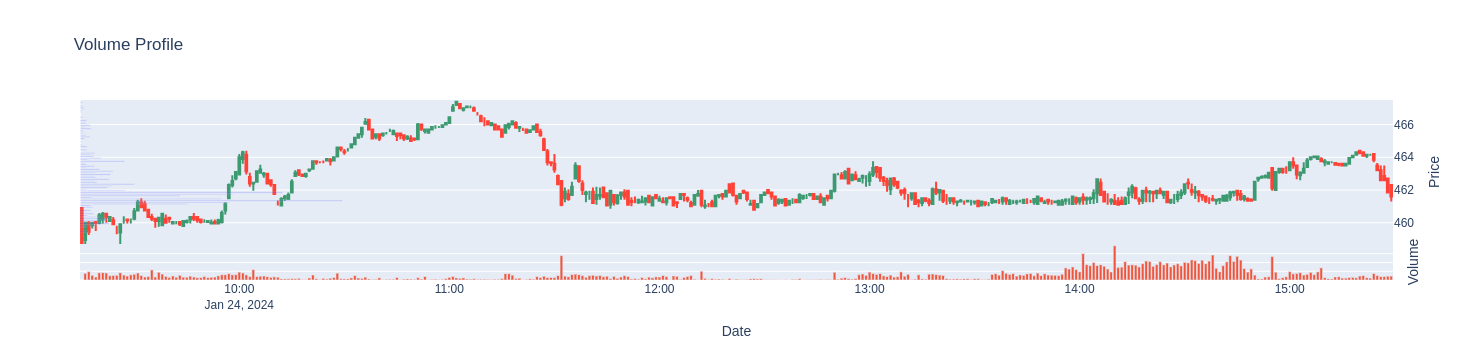

In [33]:
# change price_pace to control number of bars
fig = volume_profile(df, price_pace=0.1)
fig.show()

### TPO Profile


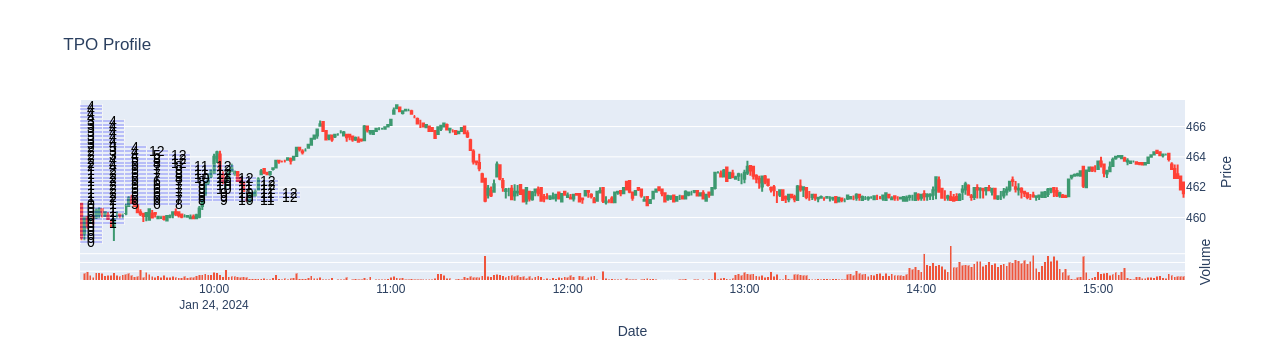

In [34]:

# change price_pace to control number of bars
# change time_space to control bar time window
# fig = market_profile(df, price_pace=0.25, time_pace='10T', return_raw=False)
fig = market_profile(df, price_pace=0.25, time_pace='30T', return_raw=False)
fig.show()
     